# RAMP on predicting cyclist traffic in Paris

Authors: *Roman Yurchak (Symerio)*; also partially inspired by the air_passengers starting kit.


## Introduction

The dataset was collected with cyclist counters installed by Paris city council in multiple locations. It contains hourly information about cyclist traffic, as well as the following features,
 - counter name
 - counter site name
 - date
 - counter installation date
 - latitude and longitude
 
Available features are quite scarce. However, **we can also use any external data that can help us to predict the target variable.** 

In [20]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns 

In [2]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

To use this function with scikit-learn estimators we wrap it with [FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html),

Since it is unlikely that, for instance, that `hour` is linearly correlated with the target variable, we would need to additionally encode categorical features for linear models. This is classically done with [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), though other encoding strategies exist.

## Analysons rapidos la donnée puisque l'on voit que l'on est au moment du covid et des confinements

## Il faut que j'ajoute les mêmes features dans le X_test sinon ça ne sert à rien

## Reprise du dataset météo 2e méthode

In [3]:
df3 = pd.read_csv('external_data.csv')

In [4]:
colonnes_à_garder = ['date', 'ff', 't', 'u', 'rr3']

In [5]:
df3 = df3[colonnes_à_garder]
df3['date'] = pd.to_datetime(df3['date'], format='%Y-%m-%d %H:%M:%S')

In [6]:
df3['date'] = pd.to_datetime(df3['date'], format='%Y-%m-%d')

<Axes: >

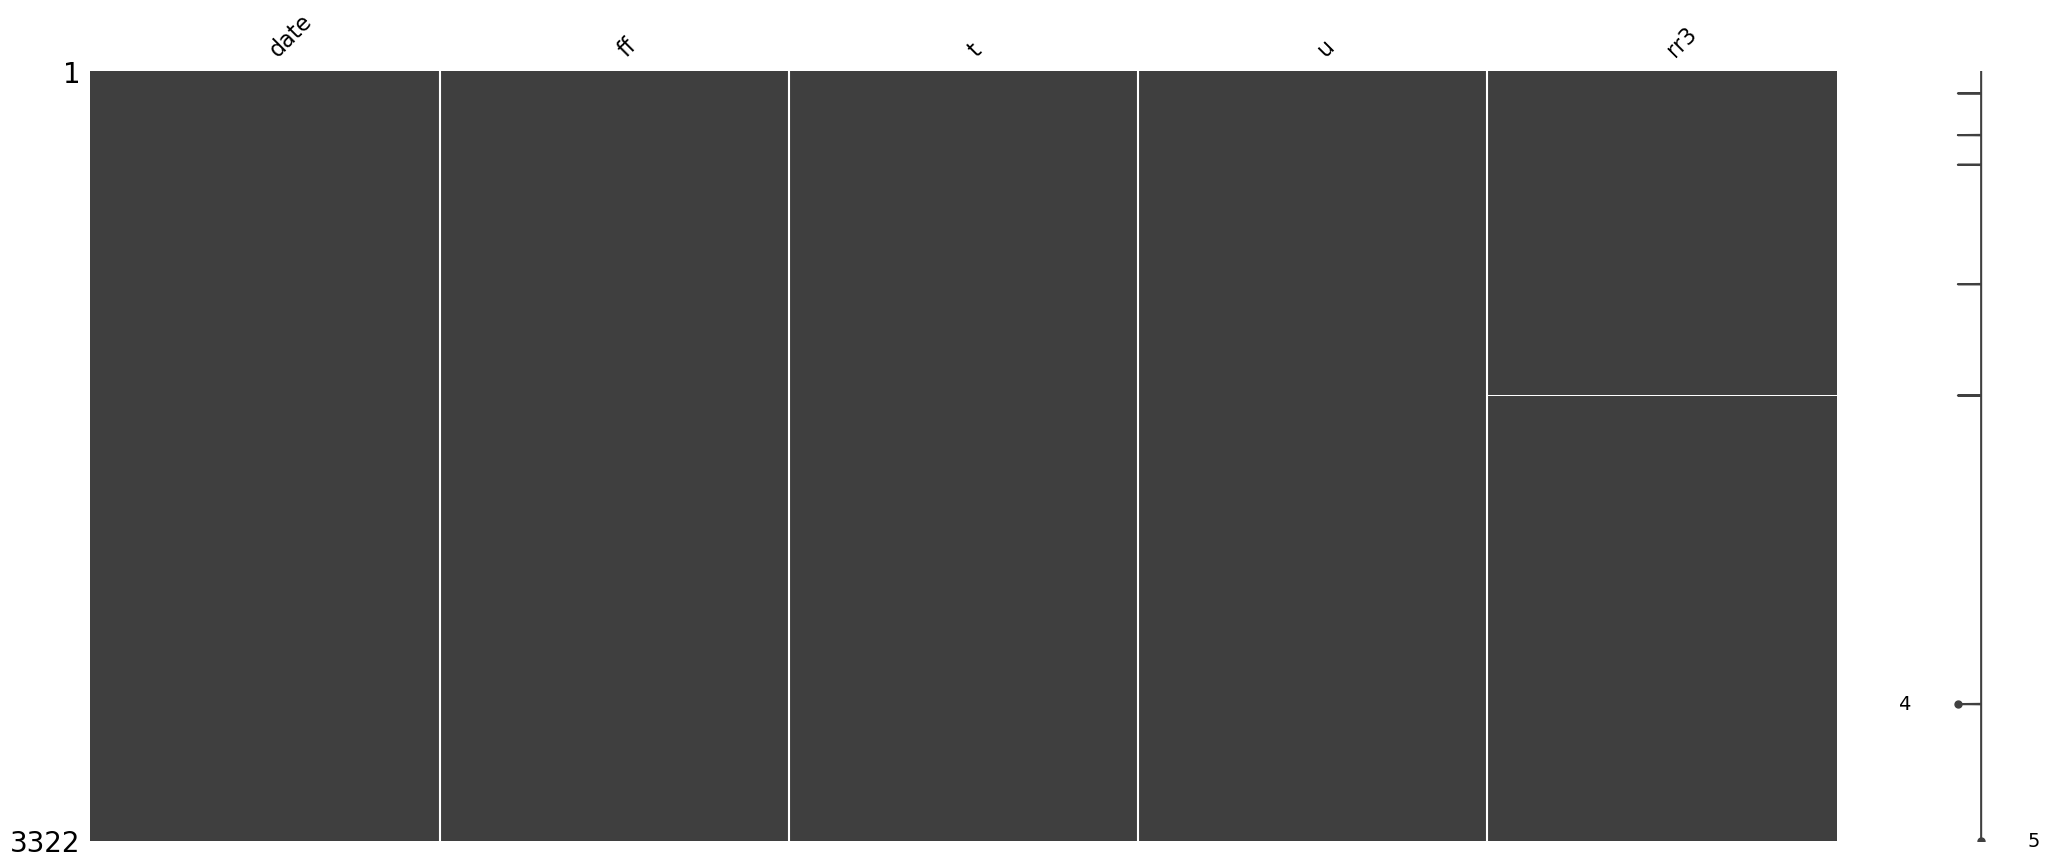

In [7]:
import missingno as msno
msno.matrix(df3)

In [8]:
df_bis = pd.read_parquet(Path("data") / "train.parquet")
df_bis.drop('counter_installation_date', axis = 1, inplace = True)
df_bis.drop('site_name', axis = 1, inplace = True)
df_bis.drop('counter_technical_id', axis = 1, inplace = True)
df_bis.drop('bike_count', axis = 1, inplace = True)
df_bis.drop('site_id', axis = 1, inplace = True) 
df_bis.drop('latitude', axis = 1, inplace = True)
df_bis.drop('longitude', axis = 1, inplace = True)
df_bis.drop('counter_name', axis= 1, inplace = True)
_encode_dates(df_bis[["date"]]).columns.tolist()
df_encoded = _encode_dates(df_bis[["date"]])
df_bis = pd.concat([df_bis, df_encoded], axis=1)

In [9]:
merged_df2 = pd.merge(df_bis, df3, how='left', on='date')

## Démarrage pour interpolation

In [10]:
columns_to_interpolate = ['ff', 't', 'u', 'rr3']
merged_df2[columns_to_interpolate] = merged_df2[columns_to_interpolate].interpolate(method='linear')
merged_df2.iloc[0] = merged_df2.iloc[1] ## Brutforce de la 1re valeur

In [11]:
## Renomme + mise en degrés
merged_df2.rename(columns={'ff': 'wind_speed'}, inplace=True)
merged_df2.rename(columns={'t': 'temperature'}, inplace=True)
merged_df2.rename(columns={'u': 'humidity'}, inplace=True)
merged_df2.rename(columns={'rr3': 'precipitation_3h'}, inplace=True)
merged_df2.rename(columns={'rr24': 'precipitation_4h'}, inplace=True)
merged_df2['temperature'] = merged_df2['temperature'] - 273.15 #Pour degrés

## Crééons une colonne pour indiquer l'influence du covid  

In [12]:
confinement_dates = pd.DataFrame({
    'debut': ['2020-03-17', '2020-10-30', '2021-04-03'],
    'fin': ['2020-05-11', '2020-12-15', '2021-05-03']
})

couvre_feu_dates = pd.DataFrame({
    'debut2': ['2020-10-17', '2020-12-15'],
    'fin2': ['2020-12-15', '2021-06-01']
})

confinement_dates['debut'] = pd.to_datetime(confinement_dates['debut'])
confinement_dates['fin'] = pd.to_datetime(confinement_dates['fin'])

couvre_feu_dates['debut2'] = pd.to_datetime(couvre_feu_dates['debut2'])
couvre_feu_dates['fin2'] = pd.to_datetime(couvre_feu_dates['fin2'])

# Créez une colonne 'periode' initialement à 0 dans merged_df2
merged_df2['periode'] = 0

# Parcourez les périodes de confinement
for _, row in confinement_dates.iterrows():
    merged_df2.loc[
        (merged_df2['date'] >= row['debut']) & (merged_df2['date'] <= row['fin']),
        'periode'
    ] = 2

# Parcourez les périodes de couvre-feu 
for _, row in couvre_feu_dates.iterrows():
    if row['fin2'] is not None:
        merged_df2.loc[
            (merged_df2['date'] >= row['debut2']) & (merged_df2['date'] <= row['fin2']) &
            (merged_df2['periode'] != 2), 
            'periode'
        ] = 1
    else:
        merged_df2.loc[
            (merged_df2['date'] >= row['debut2']) &
            (merged_df2['periode'] != 2),  
            'periode'
        ] = 1

# Vérifiez si une date est à la fois dans le confinement et le couvre-feu et attribuez 2
merged_df2['periode'] = merged_df2.groupby('date')['periode'].transform('max')

## On va plutôt encoder la pluie entre 0 et 3

In [13]:
def encode_precipitation(value):
    if value <= 0:
        return 0
    elif 0 < value < 1:
        return 1
    elif value >= 1:
        return 2

merged_df2['precipitation_encoded'] = merged_df2['precipitation_3h'].apply(encode_precipitation)

In [14]:
merged_df2['precipitation_3h'] = merged_df2['precipitation_encoded']
merged_df2 = merged_df2.drop('precipitation_encoded', axis = 1)
merged_df2['precipitation_3h'].isnull().sum()

0

## On ajoute une colonne pour les vacances

In [15]:
# Périodes de vacances scolaires pour la zone C entre le 01/09/2020 et le 31/12/2021
vacances_scolaires = [
    ('2020-10-17', '2020-11-02'),  # Vacances de la Toussaint
    ('2020-12-19', '2021-01-04'),  # Vacances de Noël
    ('2021-02-20', '2021-03-08'),  # Vacances d'hiver
    ('2021-04-10', '2021-04-26'),  # Vacances de printemps
    ('2021-07-10', '2021-09-01'),  # Vacances d'été
    ('2021-10-23', '2021-11-08'),  # Vacances de la Toussaint
    ('2021-12-18', '2022-01-03'),  # Vacances de Noël
]

for i, (debut, fin) in enumerate(vacances_scolaires):
    vacances_scolaires[i] = (pd.to_datetime(debut), pd.to_datetime(fin))

# Créez une nouvelle colonne 'vacances' avec des valeurs par défaut à 0
merged_df2['vacances'] = 0

# Marquez les jours correspondant aux vacances scolaires avec 1
for debut, fin in vacances_scolaires:
    merged_df2.loc[(merged_df2['date'] >= debut) & (merged_df2['date'] <= fin), 'vacances'] = 1

## Observation de la distribution

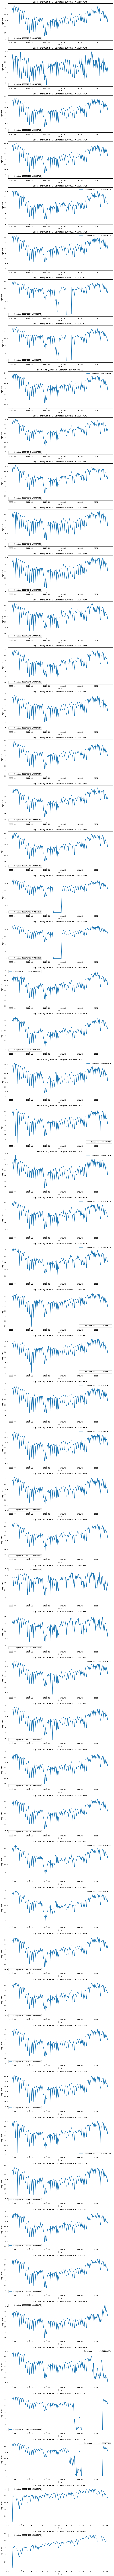

In [16]:
# Créer une figure et des axes
fig, axes = plt.subplots(nrows=len(merged_df2['counter_id'].unique()), figsize=(10, 4 * len(merged_df2['counter_id'].unique())))

# Grouper par compteur
grouped_data = merged_df2.groupby('counter_id')

# Boucle à travers chaque groupe (compteur)
for (counter_id, data_for_counter), ax in zip(grouped_data, axes):
    # Regrouper par jour et sommer les valeurs de log_bike_count
    daily_data = data_for_counter.groupby(pd.Grouper(freq="1d", key="date"))['log_bike_count'].sum()
    
    # Tracer le log count quotidien avec la fonction plot de Matplotlib
    ax.plot(daily_data.index, daily_data, label=f'Compteur {counter_id}')
    
    # Ajouter des titres et des étiquettes
    ax.set_title(f'Log Count Quotidien - Compteur {counter_id}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Log Count')
    ax.legend()  # Ajouter la légende

# Ajuster la disposition pour éviter les chevauchements
plt.tight_layout()

# Afficher le graphique
plt.show()

- bug compteur 100042374 - 109042374 entre 03 et 05/21
- idem compteur " - 110042374 ""
- idem compteur 100049407 - 353255859 entre mi 01 et 03/21
- idem compteur " - 353255860 "
- idem compteur 100063175 - 353277233 entre 05 et mi 07/21
- idem compteur " - 353277235 "

In [17]:
# Liste des conditions
conditions = [
    ((merged_df2['counter_id'] == '100042374-109042374') & ((merged_df2['date'] >= '2021-03-01') & (merged_df2['date'] <= '2021-05-31'))),
    ((merged_df2['counter_id'] == '100042374-110042374') & ((merged_df2['date'] >= '2021-03-01') & (merged_df2['date'] <= '2021-05-31'))),
    ((merged_df2['counter_id'] == '100049407-353255859') & ((merged_df2['date'] >= '2021-01-15') & (merged_df2['date'] <= '2021-03-31'))),
    ((merged_df2['counter_id'] == '100049407-353255860') & ((merged_df2['date'] >= '2021-01-15') & (merged_df2['date'] <= '2021-03-31'))),
    ((merged_df2['counter_id'] == '100063175-353277233') & ((merged_df2['date'] >= '2021-05-01') & (merged_df2['date'] <= '2021-07-15'))),
    ((merged_df2['counter_id'] == '100063175-353277235') & ((merged_df2['date'] >= '2021-05-01') & (merged_df2['date'] <= '2021-07-15')))
]

# Parcourir chaque condition
for condition in conditions:
    # Extraire les lignes correspondant à la condition
    subset = merged_df2[condition]
    
    # Identifier les lignes avec des valeurs nulles ou louches
    zero_mask = (subset['log_bike_count'] == 0)
    
    # Calculer la moyenne des valeurs non nulles
    mean_value = subset.loc[~zero_mask, 'log_bike_count'].mean()
    
    # Remplacer les valeurs nulles par la moyenne
    merged_df2.loc[condition & zero_mask, 'log_bike_count'] = mean_value


In [18]:
# Pour checker 
specific_counter_rows = merged_df2.loc[
    (merged_df2['counter_id'] == '100063175-353277233') &
    (merged_df2['date'] >= '2021-05-01') &
    (merged_df2['date'] <= '2021-07-15')
]

print(specific_counter_rows)


                 counter_id                date  log_bike_count  year  month  \
431451  100063175-353277233 2021-05-01 05:00:00        1.347108  2021      5   
431454  100063175-353277233 2021-05-01 06:00:00        1.347108  2021      5   
431457  100063175-353277233 2021-05-01 08:00:00        1.609438  2021      5   
431460  100063175-353277233 2021-05-01 09:00:00        1.347108  2021      5   
431463  100063175-353277233 2021-05-01 10:00:00        0.693147  2021      5   
...                     ...                 ...             ...   ...    ...   
435188  100063175-353277233 2021-07-14 08:00:00        1.347108  2021      7   
435191  100063175-353277233 2021-07-14 09:00:00        1.347108  2021      7   
435194  100063175-353277233 2021-07-14 10:00:00        1.347108  2021      7   
435197  100063175-353277233 2021-07-14 18:00:00        1.347108  2021      7   
435200  100063175-353277233 2021-07-14 19:00:00        1.347108  2021      7   

        day  weekday  hour  wind_speed 

# Feature selection 

## Travail sur le log_bike_count désormais

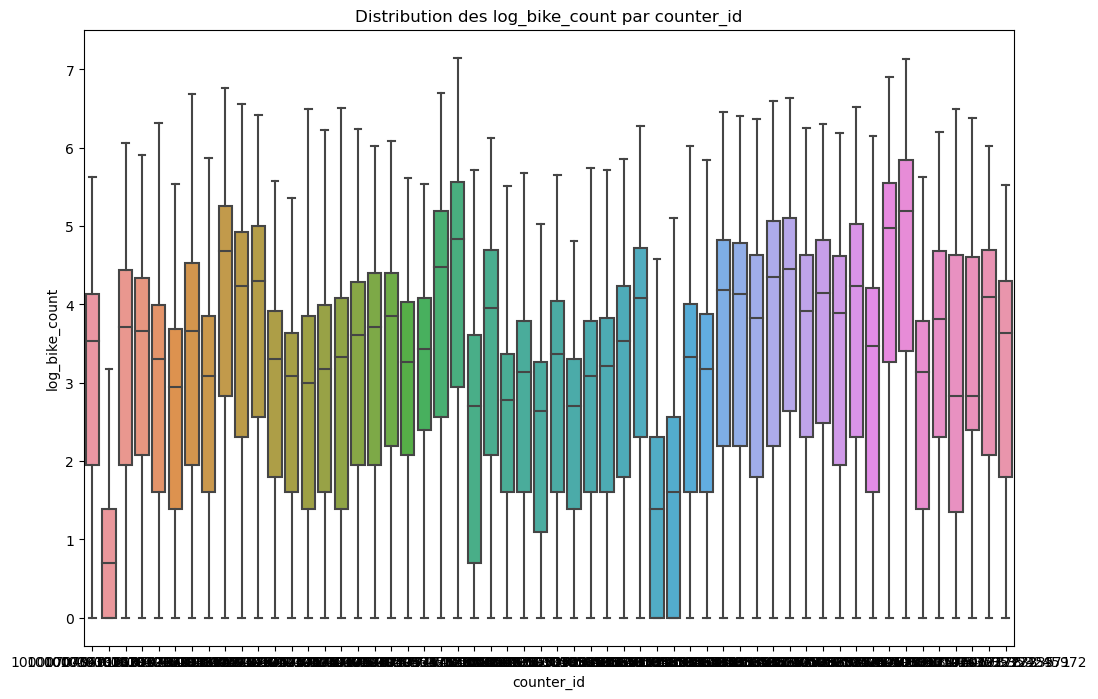

In [21]:
# Définir la taille de la figure
plt.figure(figsize=(12, 8))

# Tracer un boxplot
sns.boxplot(x='counter_id', y='log_bike_count', data=merged_df2)

# Ajouter des titres et des étiquettes
plt.title('Distribution des log_bike_count par counter_id')
plt.xlabel('counter_id')
plt.ylabel('log_bike_count')

# Afficher le graphique
plt.show()


In [22]:
## Visuellement je ne vois pas grand chose

Réglage des Paramètres du Modèle : Certains modèles d'apprentissage automatique, y compris CatBoost, offrent des paramètres qui permettent de mettre davantage l'accent sur certaines caractéristiques lors de l'apprentissage. Par exemple, dans CatBoost, vous pouvez régler le paramètre per_float_feature_quantization pour spécifier la sensibilité aux caractéristiques continues.

## Aventure périlleuse des lags

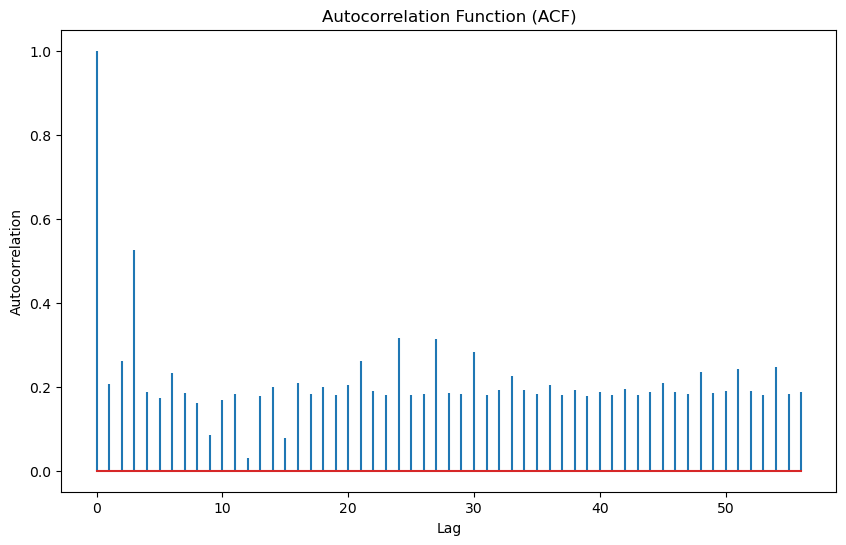

In [23]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Calculer l'ACF
acf_result = sm.tsa.acf(merged_df2['log_bike_count'], fft=True)

# Tracer l'ACF
plt.figure(figsize=(10, 6))
plt.stem(acf_result, markerfmt=' ')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()


In [24]:
num_lags = 5

# Créer des colonnes de lags dans le DataFrame
for i in range(1, num_lags + 1):
    merged_df2[f'log_bike_count_lag_{i}'] = merged_df2['log_bike_count'].shift(i)

## Essai sans lags

In [25]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

merged_df2 = merged_df2.drop('date', axis=1)

# Définition des variables
numerical_features = ['year', 'month', 'day', 'weekday', 'hour', 'temperature', 'humidity', 'precipitation_3h', 'periode', 'vacances', 'wind_speed']
categorical_cols = ["counter_id"]
target = 'log_bike_count'

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(merged_df2[numerical_features + categorical_cols], merged_df2[target], test_size=0.2)

# Création des Pools pour les données d'entraînement et de test
train_pool = Pool(X_train, label=y_train, cat_features=categorical_cols)
test_pool = Pool(X_test, label=y_test, cat_features=categorical_cols)

# Création du modèle CatBoostRegressor
regressor = CatBoostRegressor(iterations=1000, learning_rate=0.2)

# Entraînement du modèle
regressor.fit(train_pool)

# Prédictions sur l'ensemble de test
y_pred = regressor.predict(test_pool)

# Calcul de la RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")


0:	learn: 1.4181764	total: 328ms	remaining: 5m 28s
1:	learn: 1.2478100	total: 477ms	remaining: 3m 58s
2:	learn: 1.1227261	total: 594ms	remaining: 3m 17s
3:	learn: 1.0229637	total: 750ms	remaining: 3m 6s
4:	learn: 0.9448144	total: 901ms	remaining: 2m 59s
5:	learn: 0.8888243	total: 1.05s	remaining: 2m 53s
6:	learn: 0.8452192	total: 1.2s	remaining: 2m 50s
7:	learn: 0.8143122	total: 1.35s	remaining: 2m 46s
8:	learn: 0.7900135	total: 1.49s	remaining: 2m 44s
9:	learn: 0.7713390	total: 1.65s	remaining: 2m 42s
10:	learn: 0.7553932	total: 1.8s	remaining: 2m 41s
11:	learn: 0.7418506	total: 1.95s	remaining: 2m 40s
12:	learn: 0.7315748	total: 2.1s	remaining: 2m 39s
13:	learn: 0.7220274	total: 2.26s	remaining: 2m 39s
14:	learn: 0.7121321	total: 2.41s	remaining: 2m 38s
15:	learn: 0.7063611	total: 2.56s	remaining: 2m 37s
16:	learn: 0.7004340	total: 2.71s	remaining: 2m 36s
17:	learn: 0.6964556	total: 2.86s	remaining: 2m 36s
18:	learn: 0.6927358	total: 3.01s	remaining: 2m 35s
19:	learn: 0.6888371	total

## Essai avec lags

In [26]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Définition des variables
numerical_features = ['year', 'month', 'day', 'weekday', 'hour', 'temperature', 'humidity', 'precipitation_3h', 'periode', 'vacances', 'wind_speed', 'log_bike_count_lag_1', 'log_bike_count_lag_2', 'log_bike_count_lag_3', 'log_bike_count_lag_4', 'log_bike_count_lag_5']
categorical_cols = ["counter_id"]
target = 'log_bike_count'

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(merged_df2[numerical_features + categorical_cols], merged_df2[target], test_size=0.2)

# Création des Pools pour les données d'entraînement et de test
train_pool = Pool(X_train, label=y_train, cat_features=categorical_cols)
test_pool = Pool(X_test, label=y_test, cat_features=categorical_cols)

# Création du modèle CatBoostRegressor
regressor = CatBoostRegressor(iterations=1000, learning_rate=0.2)

# Entraînement du modèle
regressor.fit(train_pool)

# Prédictions sur l'ensemble de test
y_pred = regressor.predict(test_pool)

# Calcul de la RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")


0:	learn: 1.4316456	total: 189ms	remaining: 3m 8s
1:	learn: 1.2612935	total: 385ms	remaining: 3m 11s
2:	learn: 1.1229328	total: 543ms	remaining: 3m
3:	learn: 1.0178875	total: 718ms	remaining: 2m 58s
4:	learn: 0.9349655	total: 883ms	remaining: 2m 55s
5:	learn: 0.8759599	total: 1.04s	remaining: 2m 51s
6:	learn: 0.8311520	total: 1.19s	remaining: 2m 48s
7:	learn: 0.7950102	total: 1.36s	remaining: 2m 48s
8:	learn: 0.7681897	total: 1.52s	remaining: 2m 47s
9:	learn: 0.7495336	total: 1.66s	remaining: 2m 44s
10:	learn: 0.7321829	total: 1.83s	remaining: 2m 44s
11:	learn: 0.7194587	total: 2s	remaining: 2m 44s
12:	learn: 0.7087328	total: 2.19s	remaining: 2m 46s
13:	learn: 0.6992084	total: 2.33s	remaining: 2m 44s
14:	learn: 0.6920802	total: 2.5s	remaining: 2m 44s
15:	learn: 0.6852655	total: 2.67s	remaining: 2m 44s
16:	learn: 0.6798978	total: 2.82s	remaining: 2m 43s
17:	learn: 0.6742966	total: 2.99s	remaining: 2m 43s
18:	learn: 0.6700032	total: 3.17s	remaining: 2m 43s
19:	learn: 0.6676079	total: 3.3

In [27]:
regressor.get_feature_importance()

array([ 0.14695272,  4.04432712,  1.58931498,  4.53130556, 60.9185264 ,
        0.2889719 ,  0.16884767,  0.1444532 ,  4.4043847 ,  0.76423167,
        0.17524559,  0.07142745,  1.69848994,  7.384033  ,  0.43254652,
        0.20024459, 13.03669698])

## OK y'a clairement une carte à jouer sur les lags (0.42)

## Sujet de la validation croisée temporelle